In [132]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import lightgbm as lgb
import xgboost as xgb
import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import shap
from tqdm.notebook import tqdm

In [2]:
pd.options.display.max_rows = 222
pd.set_option("display.max_columns", 50)

Функции

In [3]:
def create_freq_feature(data: pd.DataFrame,
                        feature: str
                       ) -> pd.DataFrame:
    freq = data[feature].value_counts()
    data[feature] = data[feature].map(freq).astype('float')
    data[feature] = data[feature].fillna(0.0).astype('float')
    data[feature] = data[feature] / data.shape[0]
    
    return data

# клиентский профиль, некоторые знания, которые есть у компании о клиенте;
df_client_profile

In [4]:
# клиентский профиль, некоторые знания, которые есть у компании о клиенте;
df_client_profile = pd.read_csv(
    "../geekbrains-competitive-data-analysis/client_profile.csv"
)

print("client_profile.shape = {} rows, {} cols".format(*df_client_profile.shape))
df_client_profile.head()

client_profile.shape = 250000 rows, 24 cols


,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,365243,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,326,18.0,0,0,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,1726,12.0,0,0,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,365243,NaN,0,0,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [5]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

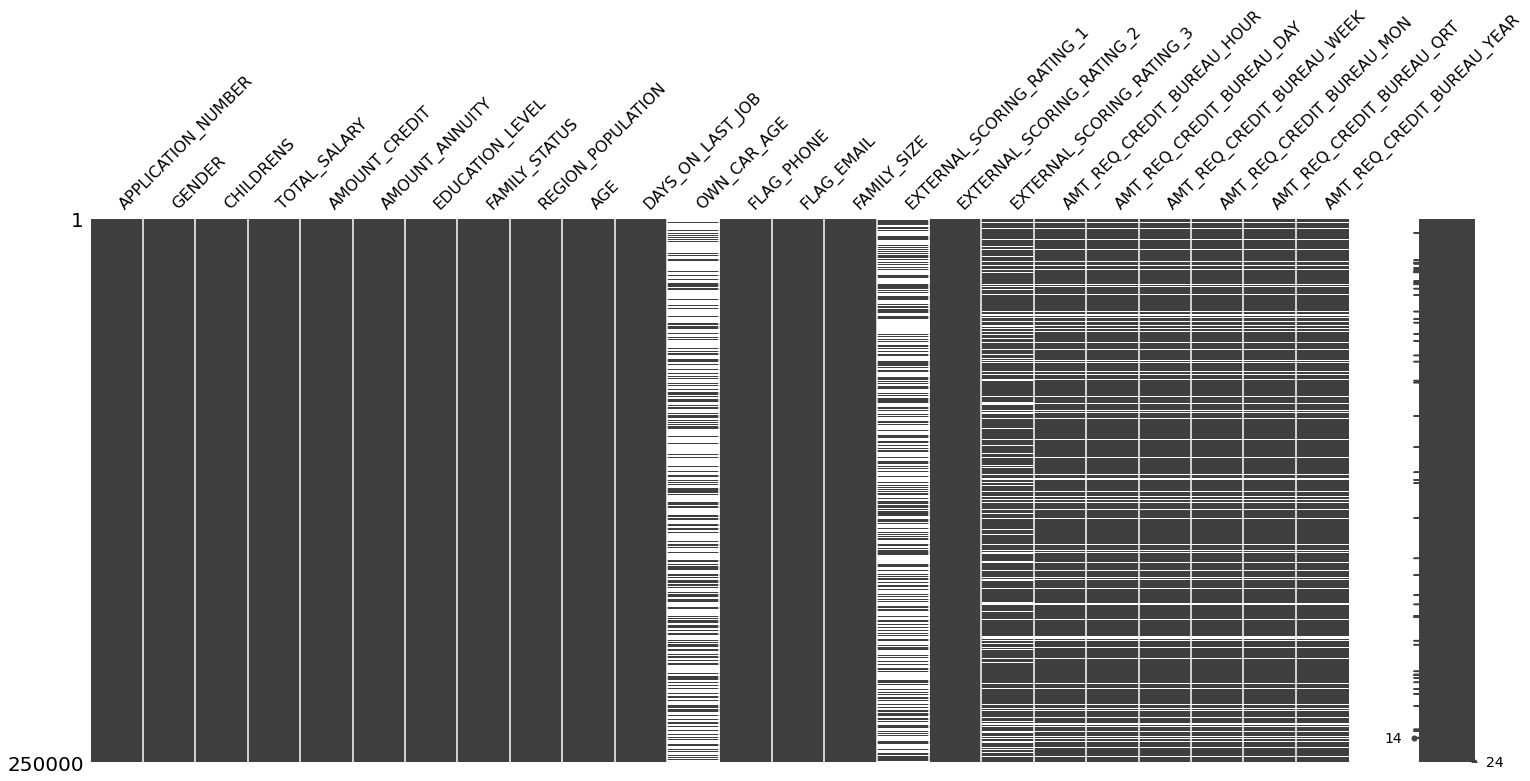

In [6]:
msno.matrix(df_client_profile)

GENDER

In [7]:
df_client_profile['GENDER'].value_counts()

F      164645
M       85351
XNA         4
Name: GENDER, dtype: int64

In [8]:
df_client_profile['GENDER'] = (df_client_profile['GENDER'] == 'F').astype(int)

FAMILY_STATUS,EDUCATION_LEVEL

In [9]:
df_client_profile['FAMILY_STATUS'].value_counts()

Married                 159846
Single / not married     36883
Civil marriage           24252
Separated                15984
Widow                    13033
Unknown                      2
Name: FAMILY_STATUS, dtype: int64

In [10]:
df_client_profile['EDUCATION_LEVEL'].value_counts()

Secondary / secondary special    177562
Higher education                  60864
Incomplete higher                  8357
Lower secondary                    3081
Academic degree                     136
Name: EDUCATION_LEVEL, dtype: int64

In [11]:
df_client_profile = create_freq_feature(df_client_profile, 'FAMILY_STATUS')
df_client_profile = create_freq_feature(df_client_profile, 'EDUCATION_LEVEL')

In [12]:
df_client_profile = df_client_profile.fillna(value=
                                             {'OWN_CAR_AGE': 0, 
                                              'EXTERNAL_SCORING_RATING_1': df_client_profile['EXTERNAL_SCORING_RATING_1'].min(),
                                              'EXTERNAL_SCORING_RATING_3': df_client_profile['EXTERNAL_SCORING_RATING_3'].min()
                                             })

df_client_profile = df_client_profile.fillna(0)

In [13]:
df_client_profile.describe().T

,count,mean,std,min,25%,50%,75%,max
APPLICATION_NUMBER,250000.0,1.235771e+08,88777.222374,1.234233e+08,1.235002e+08,1.235772e+08,1.236540e+08,1.237309e+08
GENDER,250000.0,6.585800e-01,0.474187,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
CHILDRENS,250000.0,4.176240e-01,0.722529,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.900000e+01
TOTAL_SALARY,250000.0,1.690662e+05,258847.985752,2.565000e+04,1.125000e+05,1.485000e+05,2.025000e+05,1.170000e+08
AMOUNT_CREDIT,250000.0,5.993051e+05,402272.024068,4.500000e+04,2.700000e+05,5.147775e+05,8.086500e+05,4.050000e+06
AMOUNT_ANNUITY,250000.0,2.712402e+04,14504.727260,0.000000e+00,1.652400e+04,2.493000e+04,3.461400e+04,2.301615e+05
EDUCATION_LEVEL,250000.0,5.649927e-01,0.231384,5.440000e-04,2.434560e-01,7.102480e-01,7.102480e-01,7.102480e-01
FAMILY_STATUS,250000.0,4.467937e-01,0.257469,8.000000e-06,1.475320e-01,6.393840e-01,6.393840e-01,6.393840e-01
REGION_POPULATION,250000.0,2.087081e-02,0.013827,2.900000e-04,1.000600e-02,1.885000e-02,2.866300e-02,7.250800e-02
AGE,250000.0,1.603346e+04,4361.332320,7.489000e+03,1.241500e+04,1.574400e+04,1.968100e+04,2.522900e+04


# Модель

In [140]:
df_train = pd.read_csv(
    "../geekbrains-competitive-data-analysis/train.csv"
)

df_test = pd.read_csv(
    "../geekbrains-competitive-data-analysis/test.csv"
)

print("gf_train.shape = {} rows, {} cols".format(*df_train.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))

gf_train.shape = 110093 rows, 3 cols
df_test.shape = 165141 rows, 2 cols


In [184]:
df_test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,EXTERNAL_SCORING_RATING_3,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_1,DAYS_ON_LAST_JOB,EDUCATION_LEVEL,AGE,GENDER,AMOUNT_CREDIT,AMOUNT_ANNUITY,OWN_CAR_AGE,FAMILY_STATUS,REGION_POPULATION,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_SALARY,CHILDRENS
0,123724268,1,0.000527,0.628266,0.014691,2646.0,0.710248,16007.0,0.0,1125000.0,32895.0,20.0,0.639384,0.028663,1.0,4.0,117000.0,0.0
1,123456549,1,0.188490,0.578161,0.014691,459.0,0.710248,10315.0,1.0,312768.0,17095.5,0.0,0.639384,0.019689,0.0,2.0,81000.0,2.0
2,123428178,0,0.382502,0.152544,0.014691,977.0,0.710248,13016.0,1.0,450000.0,22500.0,0.0,0.639384,0.019101,1.0,6.0,157500.0,2.0
3,123619984,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123671104,1,0.415347,0.505704,0.718604,9258.0,0.243456,17743.0,1.0,254700.0,24939.0,0.0,0.639384,0.015221,1.0,0.0,90000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165137,123536402,1,0.535276,0.665971,0.014691,10398.0,0.710248,18610.0,0.0,450000.0,16807.5,23.0,0.147532,0.028663,0.0,0.0,135000.0,0.0
165138,123718238,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165139,123631557,1,0.000527,0.761376,0.014691,365243.0,0.710248,20551.0,1.0,350181.0,36769.5,0.0,0.639384,0.030755,0.0,0.0,112500.0,0.0


In [141]:
df_train['NAME_CONTRACT_TYPE'] = (df_train['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)
df_test['NAME_CONTRACT_TYPE'] = (df_test['NAME_CONTRACT_TYPE'] == 'Cash').astype(int)

In [142]:
df_train = df_train.merge(df_client_profile_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')
df_test = df_test.merge(df_client_profile_result, left_on='APPLICATION_NUMBER', right_on='APPLICATION_NUMBER', how='left')

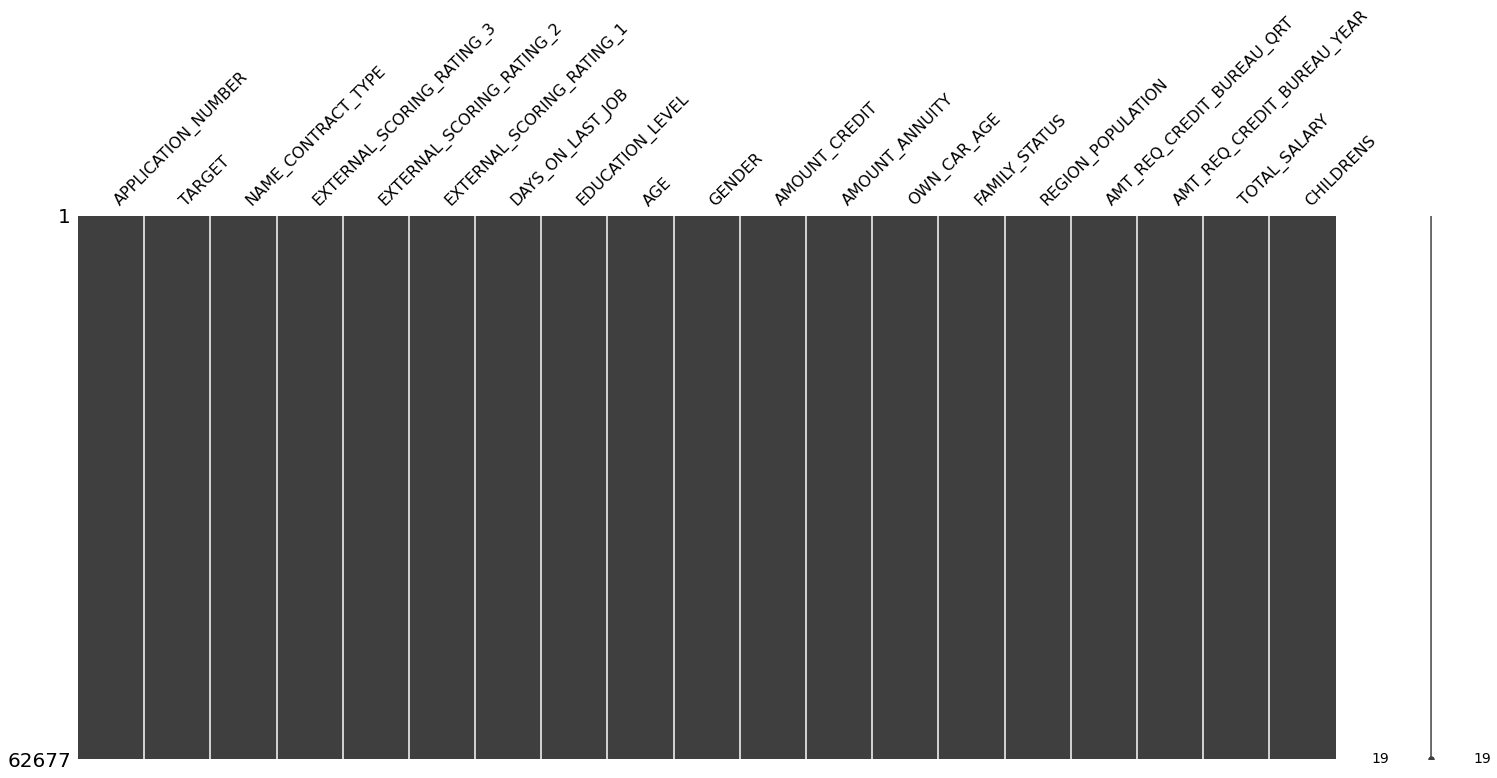

In [183]:
msno.matrix(df_train)

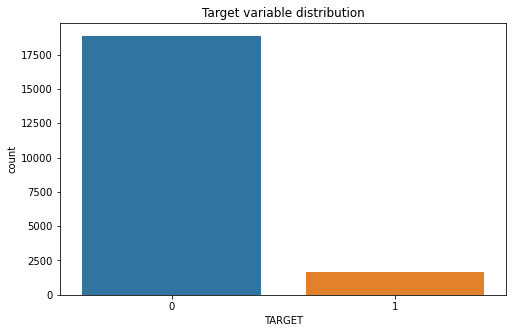

In [144]:
plt.figure(figsize=(8,5))

sns.countplot(x='TARGET',data=df_train.loc[df_train['AGE'].isnull(), :])
plt.title('Target variable distribution')

plt.show()

In [254]:
plt.figure(figsize=(8,5))

sns.countplot(x='NAME_CONTRACT_TYPE',data=df_train.loc[df_train['AGE'].isnull(), :])
plt.title('NAME_CONTRACT_TYPE')

plt.show()

ValueError: min() arg is an empty sequence

<Figure size 576x360 with 0 Axes>

In [146]:
df_train = df_train.loc[df_train['AGE'].notnull(), :]

In [147]:
df_test_null = df_test.loc[df_test['AGE'].isnull(), ['APPLICATION_NUMBER', 'NAME_CONTRACT_TYPE']]
df_test_nonull = df_test.loc[df_test['AGE'].notnull(), :]

In [148]:
FEATURE = df_train.columns
FEATURE = FEATURE.drop(['APPLICATION_NUMBER', 'TARGET'])
print(columns)
TARGET = 'TARGET'

Index(['NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_1',
       'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'AGE', 'GENDER', 'AMOUNT_CREDIT',
       'AMOUNT_ANNUITY', 'OWN_CAR_AGE', 'FAMILY_STATUS', 'REGION_POPULATION',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'TOTAL_SALARY', 'CHILDRENS'],
      dtype='object')


In [149]:
df_train, df_valid = train_test_split(df_train, 
                                      test_size=0.3,  
                                      random_state=42)

In [150]:
%%time

dtrain = xgb.DMatrix(data=df_train[FEATURE], 
                     label=df_train[TARGET])
print('*')

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.01,
    "reg_lambda": 100,
    "max_depth": 10,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=50,
    evals=[(dtrain, "train")],
    verbose_eval=200,
    maximize=True,
)

*
[0]	train-auc:0.55231
Will train until train-auc hasn't improved in 50 rounds.
[200]	train-auc:0.71586
[400]	train-auc:0.74353
[499]	train-auc:0.74985
Wall time: 36.3 s


In [151]:
x_valid_ = df_valid.sample(5000)
y_valid_ =  x_valid_[TARGET]
x_valid_ =  x_valid_[FEATURE]

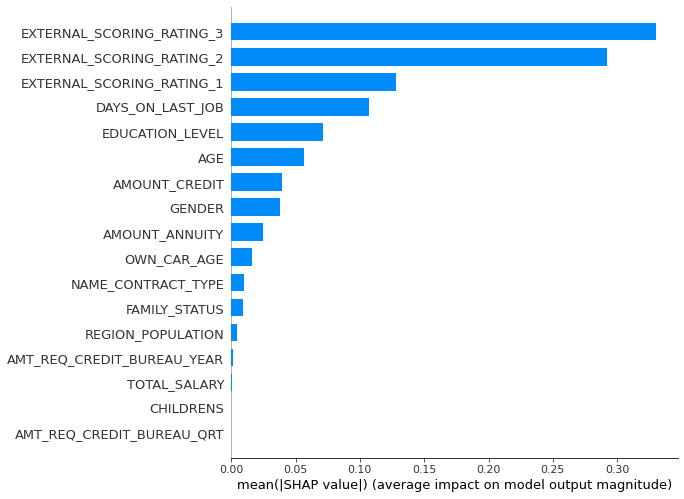

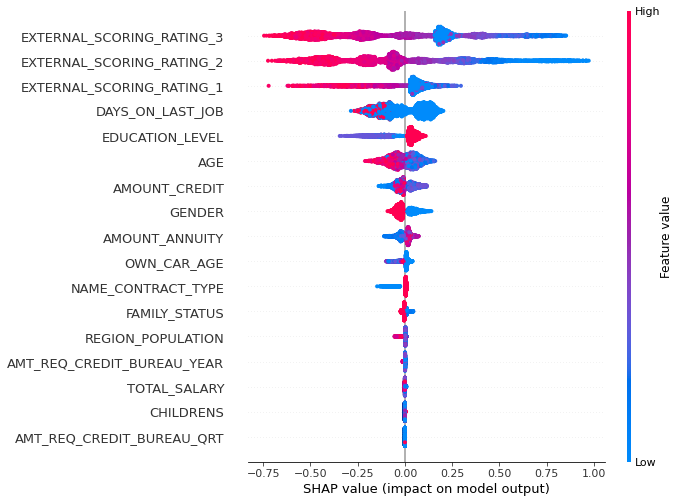

In [152]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(x_valid_, y_valid_)
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=150)
shap.summary_plot(shap_values, x_valid_, plot_type="dot")

In [153]:
mean = list()

for j in range(shap_values.shape[1]):
    bufer = 0
    for i in range(shap_values.shape[0]):
        bufer += np.abs(shap_values[i][j])
    bufer /= shap_values.shape[0]
    mean.append(bufer)

mean = np.array(mean).reshape(-1, shap_values.shape[1])

feature_importances = pd.DataFrame(mean, columns=x_valid_.columns, index=['importances'])
feature_importances = feature_importances.sort_values('importances', axis=1, ascending=0)
max_num_feature = feature_importances.loc['importances', feature_importances.loc['importances',:]>0].shape[0]
feature_high_importances = feature_importances.iloc[: ,0:max_num_feature].columns
feature_high_importances

Index(['EXTERNAL_SCORING_RATING_3', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_1', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL',
       'AGE', 'AMOUNT_CREDIT', 'GENDER', 'AMOUNT_ANNUITY', 'OWN_CAR_AGE',
       'NAME_CONTRACT_TYPE', 'FAMILY_STATUS', 'REGION_POPULATION',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'TOTAL_SALARY', 'CHILDRENS'],
      dtype='object')

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 5050, number of negative: 57627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 62677, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080572 -> initscore=-2.434603
[LightGBM] [Info] Start training from score -2.434603
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.75355	valid_1's auc: 0.730165
[200]	training's auc: 0.774452	valid_1's auc: 0.740836
[300]	training's auc: 0.79069	valid_1's auc: 0.745777
[400]	training's auc: 0.804092	valid_1's auc: 0.748326
[500]	training's auc: 0.815765	valid_1's auc: 0.749418
Early stopping, best iteration is:
[536]	training's auc: 0.819699	valid_1's auc: 0.749827


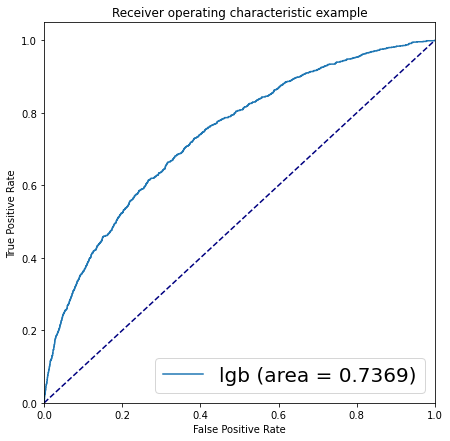

Wall time: 8.31 s


In [154]:
%%time

df_valid, df_test_ = train_test_split(df_valid, 
                                      test_size=0.5,  
                                      random_state=42)

dtrain = lgb.Dataset(data=df_train[feature_high_importances], 
                     label=df_train[TARGET])
dvalid = lgb.Dataset(data=df_valid[feature_high_importances], 
                     label=df_valid[TARGET])

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

#------------------------------------------------------------------------------
#lgb
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

pred = model_lgb.predict(df_test_[feature_high_importances])
fpr, tpr, _ = roc_curve(df_test_[TARGET], pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='lgb (area = %0.4f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.show()

In [185]:
%%time

df_valid.append(df_test_)

dtrain = lgb.Dataset(data=df_train[feature_high_importances], 
                     label=df_train[TARGET])
dvalid = lgb.Dataset(data=df_valid[feature_high_importances], 
                     label=df_valid[TARGET])

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 6,
    "seed": 27
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=100
)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 5050, number of negative: 57627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 62677, number of used features: 16
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080572 -> initscore=-2.434603
[LightGBM] [Info] Start training from score -2.434603
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.75355	valid_1's auc: 0.730165
[200]	training's auc: 0.774452	valid_1's auc: 0.740836
[300]	training's auc: 0.79069	valid_1's auc: 0.745777
[400]	training's auc: 0.804092	valid_1's auc: 0.748326
[500]	training's auc: 0.815765	valid_1's auc: 0.749418
Early stopping, best iteration is:
[536]	training's auc: 0.819699	valid_1's auc: 0.749827
Wall time: 6.42 s


In [186]:
result = model_lgb.predict(df_test_nonull[feature_high_importances])
df_test_nonull['TARGET'] = result

In [191]:
df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)

df_sample_submit.drop(['TARGET'], axis='columns', inplace=True)

df_sample_submit = df_sample_submit.merge(df_test_nonull.loc[:, ['TARGET', 'APPLICATION_NUMBER']], 
                                          left_on='APPLICATION_NUMBER', 
                                          right_on='APPLICATION_NUMBER', how='left')

df_sample_submit.loc[df_sample_submit['TARGET'].isnull(), ['TARGET']] = 0

df_sample_submit.to_csv('result.csv', index=False) 

sample_submit.shape = 165141 rows, 2 cols


In [193]:
df_sample_submit = df_sample_submit.merge(df_test_nonull.loc[:, ['TARGET', 'APPLICATION_NUMBER']], 
                                          left_on='APPLICATION_NUMBER', 
                                          right_on='APPLICATION_NUMBER', how='left')

df_sample_submit.loc[df_sample_submit['TARGET'].isnull(), ['TARGET']] = 0

In [194]:
df_sample_submit.to_csv('result.csv', index=False) 

ууууууууууу ...ука

In [200]:
feature_high_importances.shape

(16,)

Default bandwidth for data is 0; skipping density estimation.
Default bandwidth for data is 0; skipping density estimation.


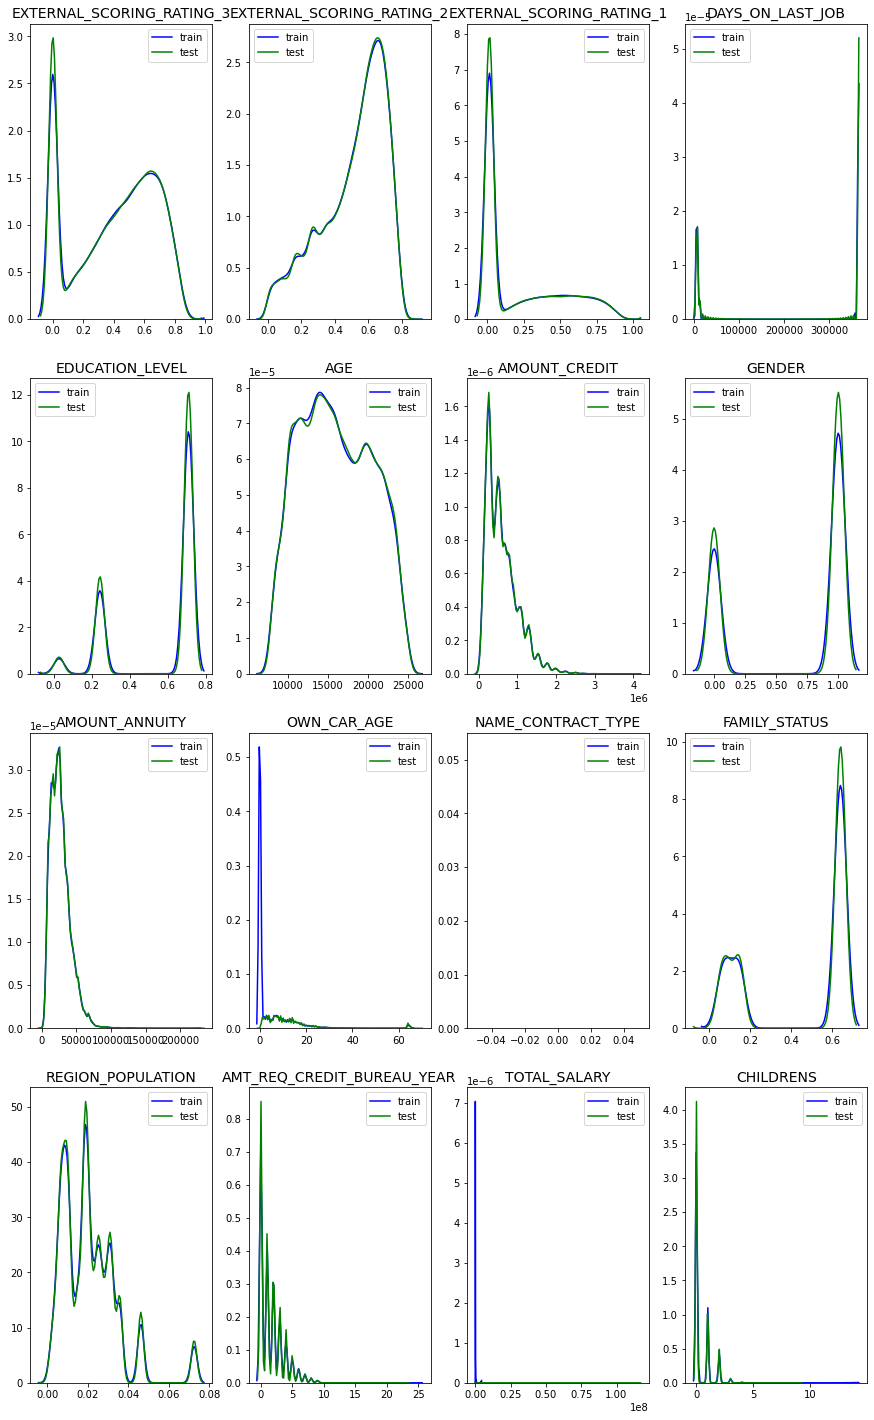

In [202]:
fig, axes = plt.subplots(4, 4, figsize=(15, 25))

#for num, feature in enumerate(continuous_feature):
#    data = train[feature].copy()
#    axes[num//3, num%3].hist(data, bins=25, color="blue")
#    axes[num//3, num%3].set_xlabel(feature, fontsize=14)
    
    

for num, feature in enumerate(feature_high_importances):
    try:
        train_data, test_data = df_train[feature].copy(), df_test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

In [203]:
feature_high_importances = feature_high_importances.drop('OWN_CAR_AGE')
feature_high_importances = feature_high_importances.drop('TOTAL_SALARY')

In [251]:
dtrain = lgb.Dataset(data=df_train[feature_high_importances], 
                     label=df_train[TARGET])
dvalid = lgb.Dataset(data=df_valid[feature_high_importances], 
                     label=df_valid[TARGET])

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "n_jobs": 3,
    "seed": 2
}

model_lgb = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=10000,
    valid_sets=[dtrain, dvalid],
    early_stopping_rounds=50,
    verbose_eval=100
)

[LightGBM] [Info] Number of positive: 5050, number of negative: 57627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 62677, number of used features: 14
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080572 -> initscore=-2.434603
[LightGBM] [Info] Start training from score -2.434603
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's auc: 0.804951	valid_1's auc: 0.744775


In [253]:
print(np.max(model_lgb.predict(df_train[feature_high_importances])))
print(np.max(model_lgb.predict(df_valid[feature_high_importances])))
print(np.max(model_lgb.predict(df_test[feature_high_importances])))

0.8205020974493126
0.6163770630601236
0.7217455247018549


In [205]:
result = model_lgb.predict(df_test_nonull[feature_high_importances])
df_test_nonull['TARGET'] = result


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [248]:
df_sample_submit = pd.read_csv(
    "../geekbrains-competitive-data-analysis/sample_submit.csv"
)

df_sample_submit.drop(['TARGET'], axis='columns', inplace=True)

df_sample_submit = df_sample_submit.merge(df_test_nonull.loc[:, ['TARGET', 'APPLICATION_NUMBER']], 
                                          left_on='APPLICATION_NUMBER', 
                                          right_on='APPLICATION_NUMBER', how='left')

df_sample_submit.loc[df_sample_submit['TARGET'].isnull(), ['TARGET']] = 0

df_sample_submit.to_csv('result.csv', index=False) 